In [1]:
from sklearn import metrics
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

# Data

In [2]:
hesc_sce = sc.read_h5ad("/home/ubuntu/data/hesc_sce.h5ad")

In [3]:
hesc_sce

AnnData object with n_obs × n_vars = 1529 × 26178
    obs: 'wellKey', 'stage', 'day', 'esc_day'
    var: 'primerid'
    uns: 'X_name'
    layers: 'counts'

In [24]:
hesc_sce.uns

{'X_name': 'logcounts'}

In [20]:
hesc_sce.obs.day

E5.5.101      embryonic day 5
E5.5.100      embryonic day 5
E6.2.114      embryonic day 6
E6.2.104      embryonic day 6
E6.2.107      embryonic day 6
                   ...       
E3.49.3407    embryonic day 3
E3.51.3426    embryonic day 3
E3.47.3391    embryonic day 3
E3.52.3431    embryonic day 3
E3.53.3438    embryonic day 3
Name: day, Length: 1529, dtype: category
Categories (5, object): ['embryonic day 3', 'embryonic day 4', 'embryonic day 5', 'embryonic day 6', 'embryonic day 7']

# Run Pypsupertime

In [7]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels

# copy so we can re-run
hesc_copy = hesc_sce.copy()

psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    n_jobs=5,
                    n_batches=1)

anndata = psuper.run(hesc_copy, "esc_day")

Input Data: n_genes=26178, n_cells=1529
Preprocessing: done. mode='hvg', n_genes=3757, n_cells=1529
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.698496.02, n_genes=64
Total elapsed time:  0:17:24.555959


Best idx: 25 Best Score: 0.7521354334083361 Best Lambda: 0.002728333376486769 Scores std: 0.16706284963587004
1SE idx: 17 1SE Score: 0.6298403514411228 1SE Lambda: 0.0180472176682717


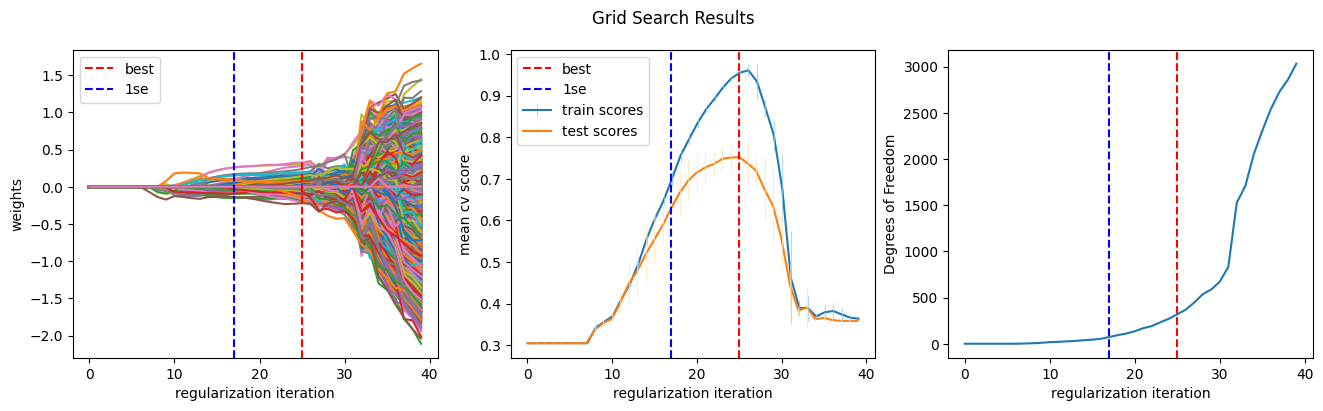

In [8]:
_ = psuper.plot_grid_search()

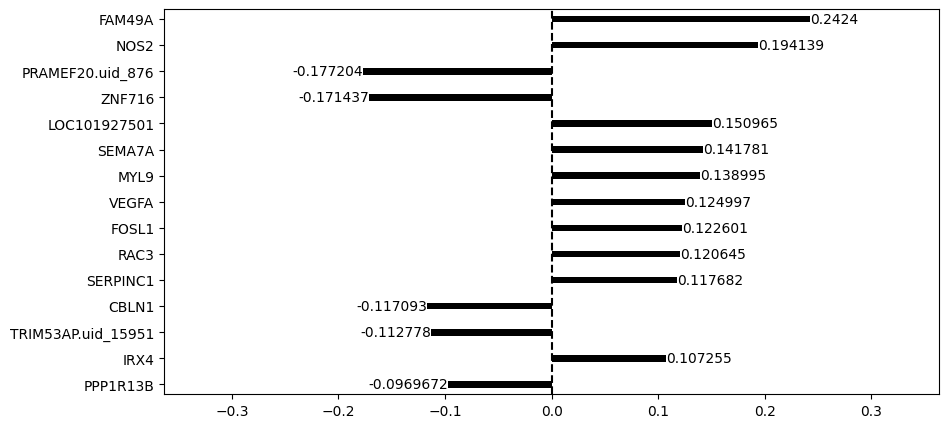

In [9]:
_ = psuper.plot_identified_gene_coefficients(anndata, n_top=15, figsize=(10,5))

Model Degrees of freedom 64
Accuracy: 0.6984957488554611
Balanced accuracy: 0.6825369711459911
Mean absolute delta: 0.3178922134033652


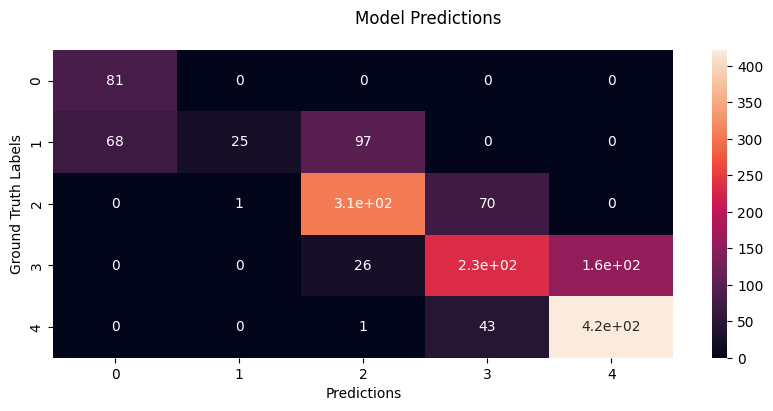

In [10]:
_ = psuper.plot_model_perf(train=(anndata.X, anndata.obs.ordinal_label))

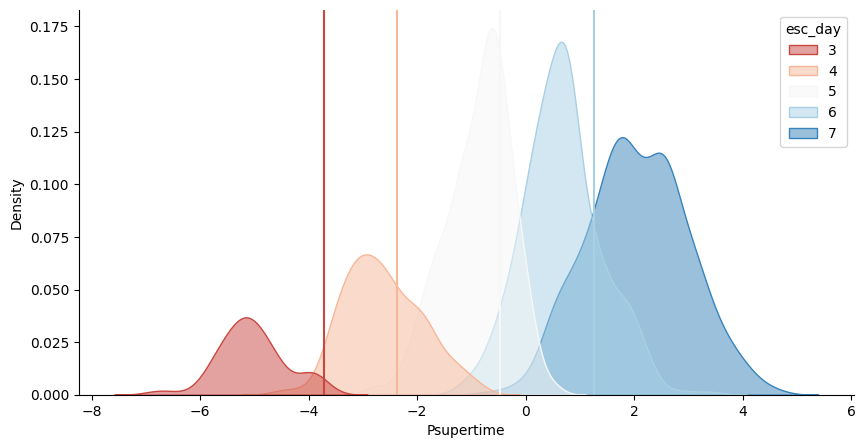

In [11]:
fig = psuper.plot_labels_over_psupertime(anndata, "esc_day")

In [12]:
from sklearn import metrics
print("Abs Error:", metrics.mean_absolute_error(anndata.obs.ordinal_label, anndata.obs.predicted_label))
print("Balanced Acc:", metrics.balanced_accuracy_score(anndata.obs.ordinal_label, anndata.obs.predicted_label))

n_genes_start = 26178
dof =  np.count_nonzero(psuper.model.coef_)
print("DoF (sparsity): %s (%s)" % (dof, 1 - (dof / n_genes_start) ))

Abs Error: 0.302158273381295
Balanced Acc: 0.6825369711459911
DoF (sparsity): 64 (0.9975551990220796)


## Repeat on Different Seeds

In [13]:
seeds = [27, 631, 54, 42, 9]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [15]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "hvg"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run(hesc_sce.copy(), "esc_day")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 27
Input Data: n_genes=26178, n_cells=1529
Preprocessing: done. mode='hvg', n_genes=3757, n_cells=1529
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.690647.02, n_genes=69
Total elapsed time:  0:14:36.466189
Input Data: n_genes=3757, n_cells=1529
Refit on all data: done. accuracy=0.940484.02, n_genes=328
Iter 1, seed 631
Input Data: n_genes=26178, n_cells=1529
Preprocessing: done. mode='hvg', n_genes=3757, n_cells=1529
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.697842.02, n_genes=68
Total elapsed time:  0:19:14.786060
Input Data: n_genes=3757, n_cells=1529
Refit on all data: done. accuracy=0.908437.02, n_genes=281
Iter 2, seed 54
Input Data: n_genes=26178, n_cells=1529
Preprocessing: done. mode='hvg', n_genes=3757, n_cells=1529
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.689339.02, n_genes=64
Total elapsed time:  0:15:46.560767

## Repeat on Different Seeds (on ALL Genes)

In [25]:
seeds = [27, 631, 54, 42, 9]
acc_best = []
acc_1se = []
bacc_best = []
bacc_1se = []
dof_best = []
dof_1se = []

In [26]:
from pypsupertime import Psupertime
from pypsupertime.preprocessing import transform_labels
import scanpy as sc

for i, s in enumerate(seeds):
    print("Iter %i, seed %i" % (i, s))
    
    psuper = Psupertime(preprocessing_params={"scale": True, "normalize": False, "log": False, "smooth": False, "select_genes": "all"},
                    n_jobs=5,
                    n_batches=1,
                    random_state=s)
    adata = psuper.run(hesc_sce.copy(), "esc_day")

    acc_1se.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_1se.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_1se.append(dof)

    # refit and predict best model
    psuper.refit_and_predict(adata, "best")
    acc_best.append(metrics.accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    bacc_best.append(metrics.balanced_accuracy_score(adata.obs.ordinal_label, adata.obs.predicted_label))
    dof =  np.count_nonzero(psuper.model.coef_)
    dof_best.append(dof)

Iter 0, seed 27
Input Data: n_genes=26178, n_cells=1529
Preprocessing: done. mode='all', n_genes=20833, n_cells=1529
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.687377.02, n_genes=38
Total elapsed time:  1:54:59.155366
Input Data: n_genes=20833, n_cells=1529
Refit on all data: done. accuracy=0.885546.02, n_genes=126
Iter 1, seed 631
Input Data: n_genes=26178, n_cells=1529
Preprocessing: done. mode='all', n_genes=20833, n_cells=1529
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.693918.02, n_genes=38
Total elapsed time:  1:29:28.317207
Input Data: n_genes=20833, n_cells=1529
Refit on all data: done. accuracy=0.898627.02, n_genes=115
Iter 2, seed 54
Input Data: n_genes=26178, n_cells=1529
Preprocessing: done. mode='all', n_genes=20833, n_cells=1529
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.689339.02, n_genes=35
Total elapsed time:  1:06:43.7

In [29]:
import numpy as np

def latex_tabular_fmt(acc, dof, n):
    acc_mean = np.round(np.mean(acc) * 100, 2)
    sparsity_mean = np.round((1 - (np.mean(dof) / n)) * 100, 2)
    acc_std = np.round(np.std(acc) * 100, 1)
    sparsity_std = np.round((np.std(dof) / n) * 100, 1)

    latex_template = "$%s \\pm %s$  &  $%s \\pm %s$"
    return latex_template % (acc_mean, acc_std, sparsity_mean, sparsity_std)

num_input_genes = 20833

print("1se model")
print("accuracy: %s (%s)" % (np.mean(acc_1se), np.std(acc_1se)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_1se), np.std(bacc_1se)))
print("dof: %s (%s)" % (np.mean(dof_1se) , np.std(dof_1se)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_1se) / num_input_genes), np.std(dof_1se) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_1se, dof_1se, num_input_genes))
print()

print("best model")
print("accuracy: %s (%s)" % (np.mean(acc_best), np.std(acc_best)))
print("balanced accuracy: %s (%s)" % (np.mean(bacc_best), np.std(bacc_best)))
print("dof: %s (%s)" % (np.mean(dof_best) , np.std(dof_best)))
print("Sparsity (all genes): %s (%s)" % (1 - (np.mean(dof_best) / num_input_genes), np.std(dof_best) / num_input_genes))
print("LATEX: accuracy & sparsity \\\\")
print(latex_tabular_fmt(acc_best, dof_best, num_input_genes))


1se model
accuracy: 0.6813603662524524 (0.016768497542881493)
balanced accuracy: 0.6547625494750029 (0.012781734474138015)
dof: 36.0 (2.756809750418044)
Sparsity (all genes): 0.9982719723515576 (0.00013232898528383068)
LATEX: accuracy & sparsity \\
$68.14 \pm 1.7$  &  $99.83 \pm 0.0$

best model
accuracy: 0.8967952910398953 (0.01708187893595643)
balanced accuracy: 0.8726533801852039 (0.026328288576157183)
dof: 119.6 (4.498888751680798)
Sparsity (all genes): 0.9942591081457304 (0.0002159501152825228)
LATEX: accuracy & sparsity \\
$89.68 \pm 1.7$  &  $99.43 \pm 0.0$
